In [ ]:
%%bash

pip install -q cython pyyaml 'pycocotools>=2.0.2'
pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

git clone https://github.com/facebookresearch/detectron2 detectron2_repo
pip install -q -e detectron2_repo

wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
unzip balloon_dataset.zip > /dev/null

In [1]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import glob
import os
import ntpath
import numpy as np
import cv2
import random
import itertools
import pandas as pd
from tqdm import tqdm
import urllib
import json
import logging
import PIL.Image as Image

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode
from detectron2.engine.hooks import BestCheckpointer, Checkpointer
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from google.colab.patches import cv2_imshow

%matplotlib inline


In [2]:
class CocoTrainer(DefaultTrainer):
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"
    return COCOEvaluator(dataset_name, cfg, False, output_folder)


In [3]:
RANDOM_SEED = 1337
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Data preparation

In [4]:
DIR_TRAIN = "balloon/train/"
DIR_VAL = "balloon/val/"
json_file = os.path.join(DIR_TRAIN, "via_region_data.json")
records = dict(train=list(), val=list())
for scope in ["train", "val"]:
  dir_path = f"balloon/{scope}/"
  json_path = os.path.join(dir_path, "via_region_data.json")
  with open(json_path) as fp:
    obj = json.load(fp)
  # records = list()
  for idx, value in enumerate(obj.values()):
    fpath = os.path.join(dir_path, value["filename"])
    image = cv2.imread(fpath)
    height, width, _ = image.shape
    annotations = list()
    for _, region in value["regions"].items():
      assert not region["region_attributes"]
      px = region["shape_attributes"]["all_points_x"]
      py = region["shape_attributes"]["all_points_y"]
      poly = list()
      for x, y in zip(px, py):
        poly.extend([x + 0.5, y + 0.5])
      annotation = {
        "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
        "bbox_mode": BoxMode.XYXY_ABS,
        "segmentation": [poly],
        "category_id": 0,
      }
      annotations.append(annotation)
    record = {
      "file_name": fpath,
      "image_id": idx,
      "height": height,
      "width": width,
      "annotations": annotations
    }
    records[scope].append(record)
  DatasetCatalog.register(f"balloon_{scope}", lambda: records[scope])
  MetadataCatalog.get(f"balloon_{scope}").set(thing_classes=["balloon"])


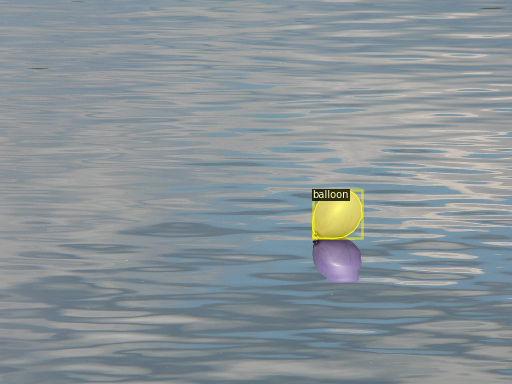

In [5]:
balloon_metadata = MetadataCatalog.get("balloon_train")
dataset_dicts = records["train"]
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

# Train

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
from detectron2.config import get_cfg


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ("balloon_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# cfg.MODEL.DEVICE='cpu'
cfg.OUTPUT_DIR = "/content/drive/MyDrive/portflio/CV/CV/02_mrcnn_detectron2/output"
cfg.TEST.EVAL_PERIOD = 50

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.register_hooks(
  hooks=[
    BestCheckpointer(
      eval_period=50,
      checkpointer=Checkpointer(
        model=trainer.model, 
        save_dir=(
          "/content/drive/MyDrive/portflio/CV/CV/02_mrcnn_detectron2/ckpt"
        ),
        trainer=trainer
      ),
      # val_metric="AP50",
      val_metric="loss_mask",
      mode="min",
      file_prefix="model_best",
    )
  ]
)


[03/28 07:42:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

In [26]:
for param in trainer.model.parameters():
  param.requires_grad = False

for param in trainer.model.roi_heads.parameters():
  param.requires_grad = True

n_params_trainable = 0
print("trainable layers:")
for name, param in trainer.model.named_parameters():
  if param.requires_grad:
    n = param.numel()
    print(f"\t{name}: {n}")
    n_params_trainable += n

n_params_total = sum(p.numel() for p in trainer.model.parameters())
print(f"number trainable of parameters: {n_params_trainable}")
print(f"total number of parameters: {n_params_total}")
print(
  f"proportion of trainable parameters: {n_params_trainable/n_params_total}"
)


trainable layers:
	roi_heads.box_head.fc1.weight: 12845056
	roi_heads.box_head.fc1.bias: 1024
	roi_heads.box_head.fc2.weight: 1048576
	roi_heads.box_head.fc2.bias: 1024
	roi_heads.box_predictor.cls_score.weight: 2048
	roi_heads.box_predictor.cls_score.bias: 2
	roi_heads.box_predictor.bbox_pred.weight: 4096
	roi_heads.box_predictor.bbox_pred.bias: 4
	roi_heads.mask_head.mask_fcn1.weight: 589824
	roi_heads.mask_head.mask_fcn1.bias: 256
	roi_heads.mask_head.mask_fcn2.weight: 589824
	roi_heads.mask_head.mask_fcn2.bias: 256
	roi_heads.mask_head.mask_fcn3.weight: 589824
	roi_heads.mask_head.mask_fcn3.bias: 256
	roi_heads.mask_head.mask_fcn4.weight: 589824
	roi_heads.mask_head.mask_fcn4.bias: 256
	roi_heads.mask_head.deconv.weight: 262144
	roi_heads.mask_head.deconv.bias: 256
	roi_heads.mask_head.predictor.weight: 256
	roi_heads.mask_head.predictor.bias: 1
number trainable of parameters: 16524807
total number of parameters: 43918038
proportion of trainable parameters: 0.3762646910592864


In [27]:
trainer.train()

[03/28 07:42:30 d2.engine.train_loop]: Starting training from iteration 0
[03/28 07:42:43 d2.utils.events]:  eta: 0:02:45  iter: 19  total_loss: 2.121  loss_cls: 0.7912  loss_box_reg: 0.542  loss_mask: 0.6888  loss_rpn_cls: 0.04952  loss_rpn_loc: 0.01572  time: 0.5906  data_time: 0.0302  lr: 1.6068e-05  max_mem: 2335M
[03/28 07:42:55 d2.utils.events]:  eta: 0:02:35  iter: 39  total_loss: 1.865  loss_cls: 0.6431  loss_box_reg: 0.5384  loss_mask: 0.6081  loss_rpn_cls: 0.0372  loss_rpn_loc: 0.01253  time: 0.5965  data_time: 0.0114  lr: 3.2718e-05  max_mem: 2335M
[03/28 07:43:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/28 07:43:01 d2.data.common]: Serializing 13 elements to byte tensors and concatenating them all ...
[03/28 07:43:01 d2.data.common]: Serialized dataset takes 0.04 MiB
WARNING [03/28 07:43:01 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated 

# Result visualization

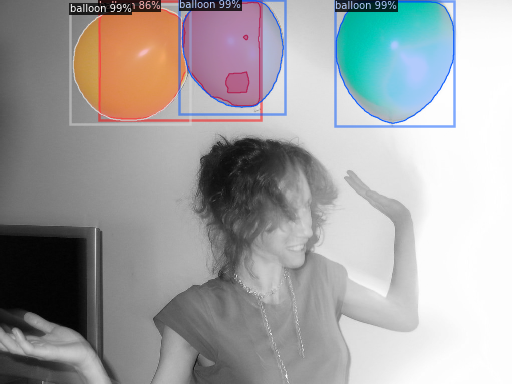

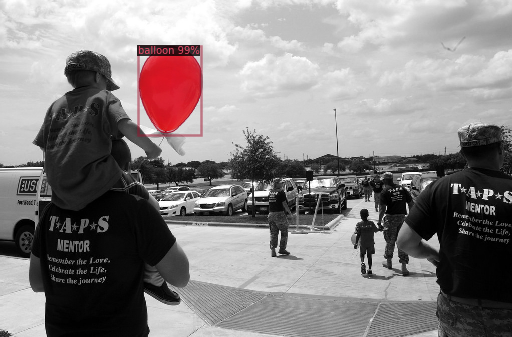

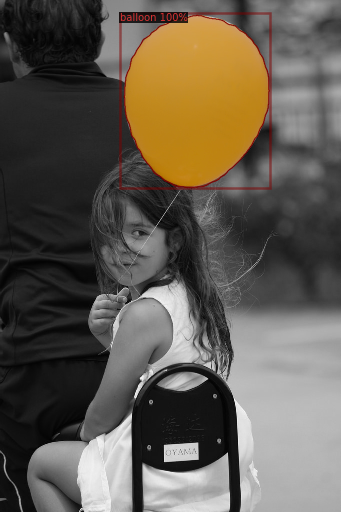

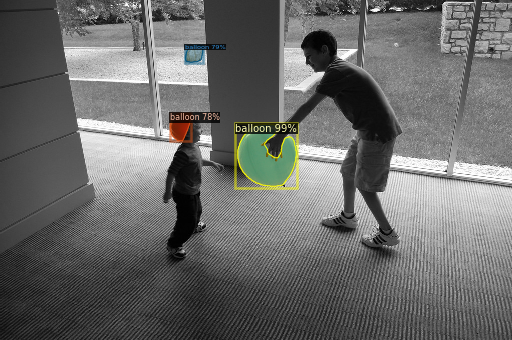

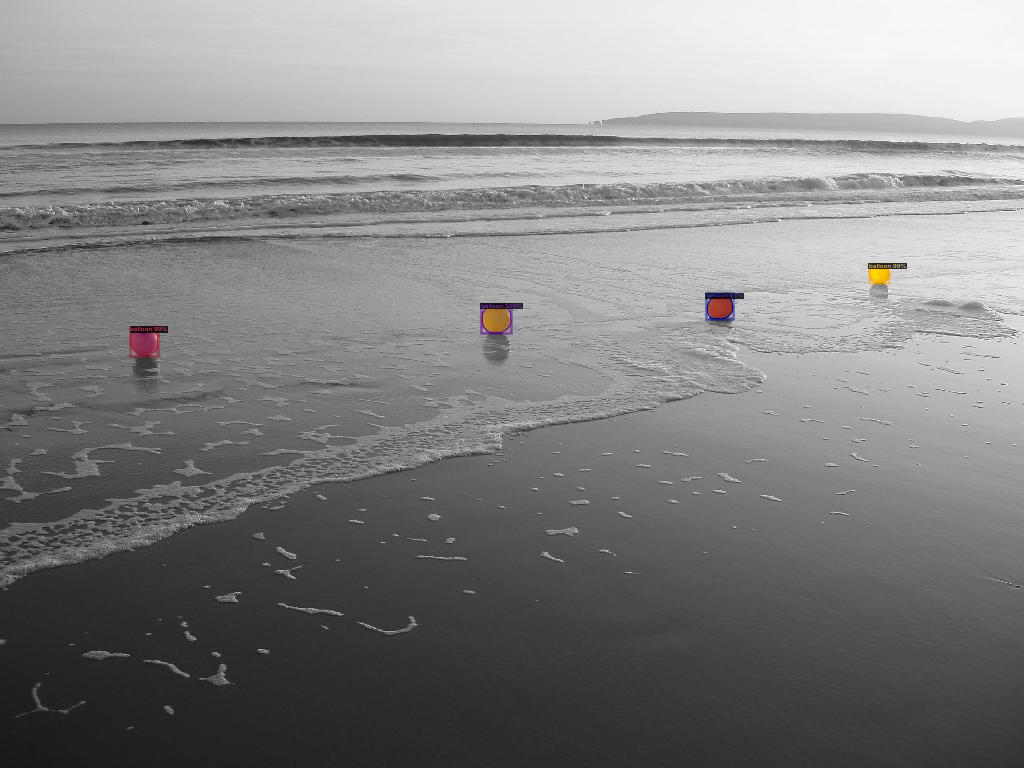

In [13]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

from detectron2.utils.visualizer import ColorMode
dataset_dicts = records["val"]
for d in random.sample(dataset_dicts, 5):    
  im = cv2.imread(d["file_name"])
  outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
  v = Visualizer(
    im[:, :, ::-1],
    metadata=balloon_metadata, 
    scale=0.5, 
    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
  )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])